## Fitting Model to Thermomat Data
#### See Labuschagne paper for model

In [1]:
%pylab inline
from datahandling import alldatafiles, DataFile, file_parse
from time import time as tm
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from lmfit import Parameters, minimize, report_fit
from thermomat_functions import cond_model, f2min, find_cut_point, rand_ini_val, parameters
from os import path

Populating the interactive namespace from numpy and matplotlib


C:\Users\Reinhard\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Read files and define parameters

In [3]:
Files = alldatafiles()

In [4]:
Files

[]

#### Data Fitting

Completed Fit 1 in 0.73 (s)
Completed Fit 2 in 0.27 (s)
Completed Fit 3 in 0.76 (s)
Completed Fit 4 in 0.32 (s)
Completed Fit 5 in 9.45 (s)
Completed Fit 6 in 0.25 (s)
Completed Fit 7 in 0.93 (s)
Completed Fit 8 in 2.61 (s)
Completed Fit 9 in 0.47 (s)
Completed Fit 10 in 1.5 (s)
Completed Fit 11 in 0.38 (s)
Completed Fit 12 in 1.72 (s)
Completed Fit 13 in 8.91 (s)
Completed Fit 14 in 13.24 (s)
Completed Fit 15 in 0.42 (s)
Completed Fit 16 in 12.06 (s)
Completed Fit 17 in 1.28 (s)
Completed Fit 18 in 4.46 (s)
Completed Fit 19 in 0.74 (s)
Completed Fit 20 in 0.26 (s)
Completed Fit 21 in 0.34 (s)
Completed Fit 22 in 39.74 (s)
Completed Fit 23 in 218.27 (s)
Completed Fit 24 in 0.46 (s)
Completed Fit 25 in 0.77 (s)
Completed Fit 26 in 0.53 (s)
Completed Fit 27 in 4.77 (s)
Completed Fit 28 in 0.34 (s)
Completed Fit 29 in 8.09 (s)
Completed Fit 30 in 0.79 (s)
Completed Fit 31 in 0.61 (s)
Completed Fit 32 in 0.39 (s)
Completed Fit 33 in 14.69 (s)
Completed Fit 34 in 0.58 (s)
Completed Fit 35 i

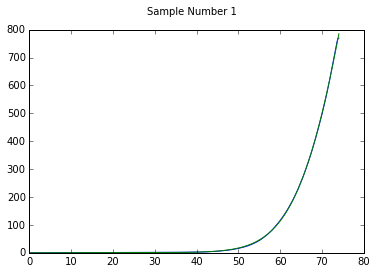

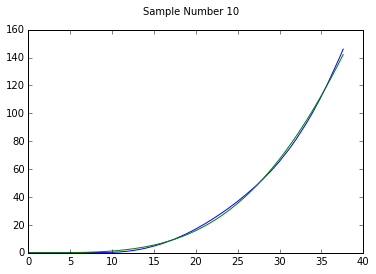

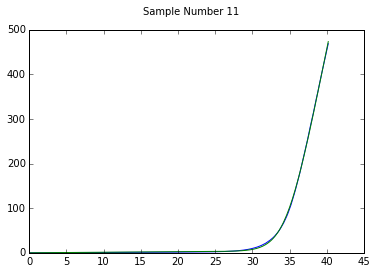

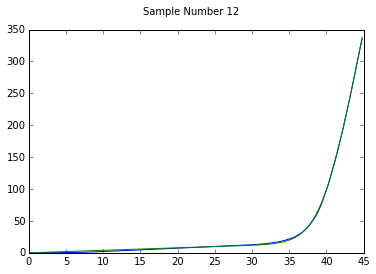

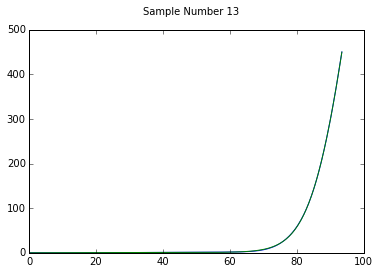

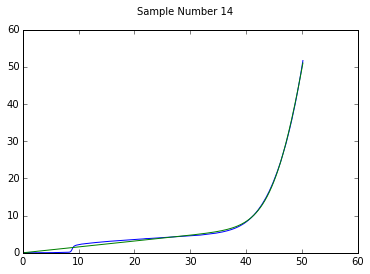

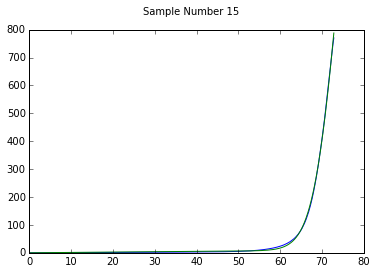

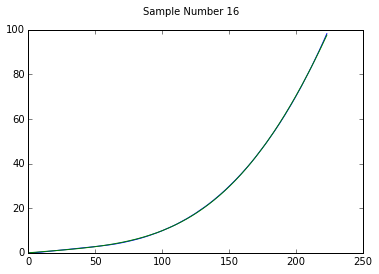

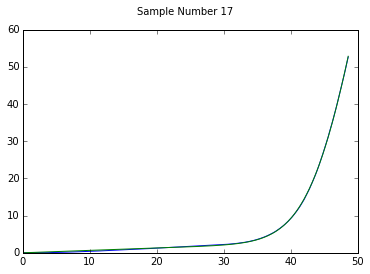

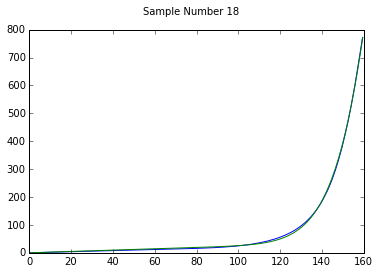

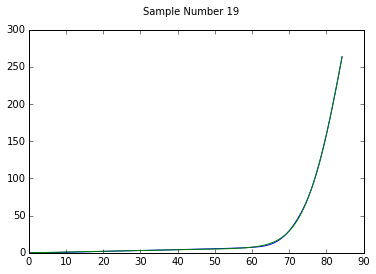

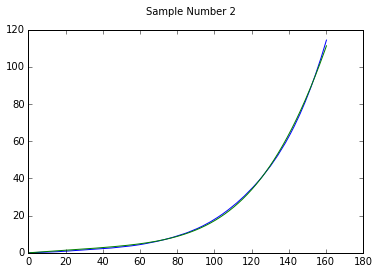

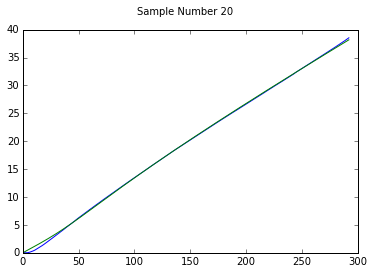

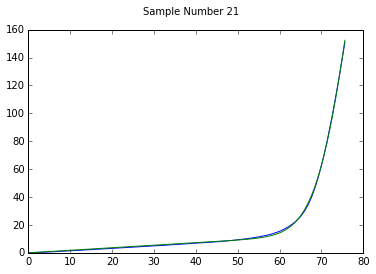

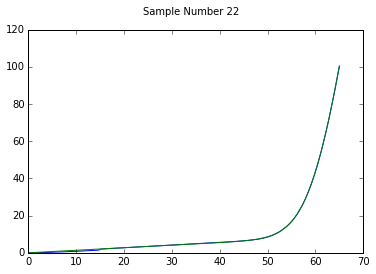

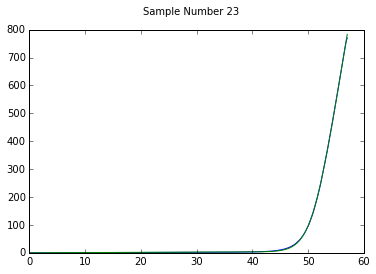

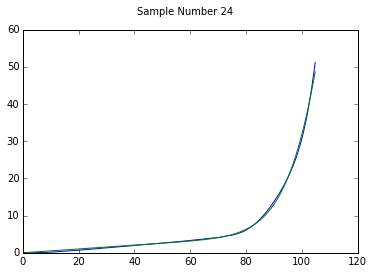

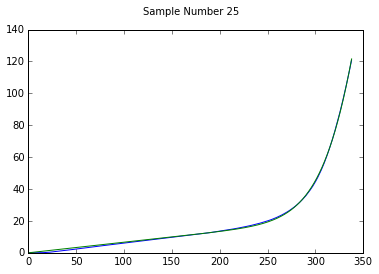

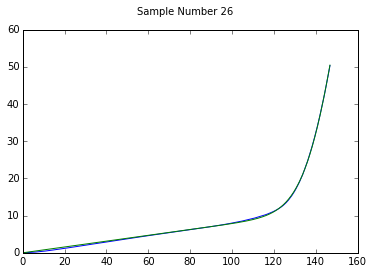

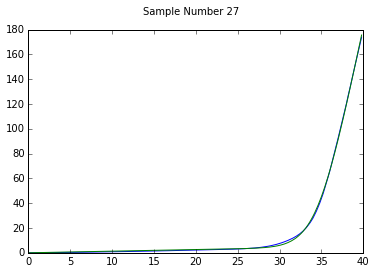

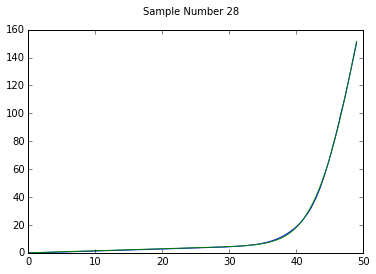

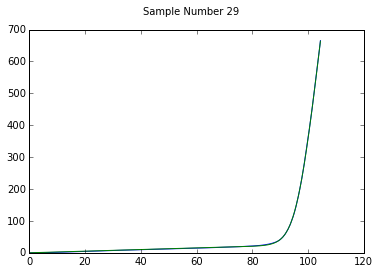

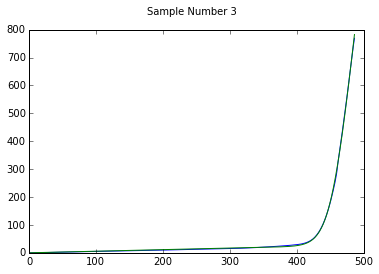

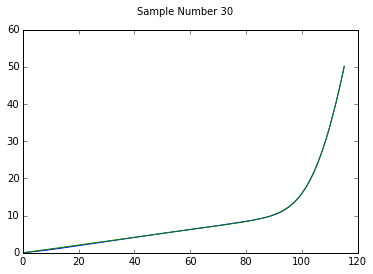

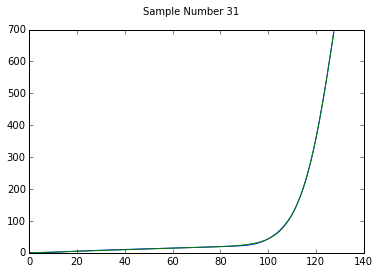

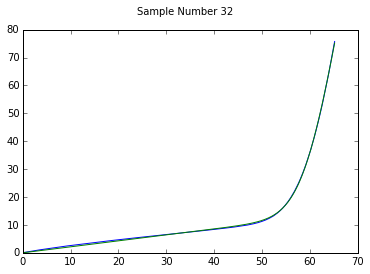

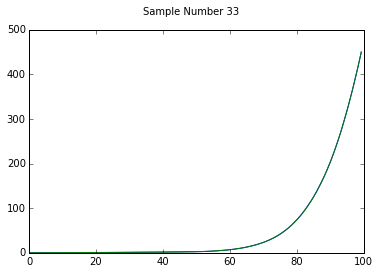

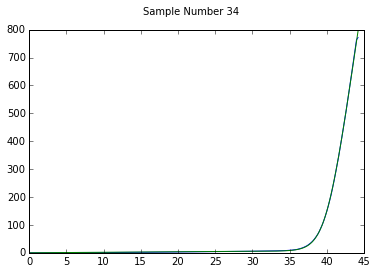

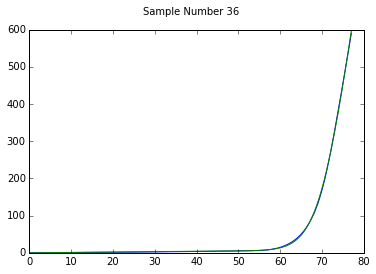

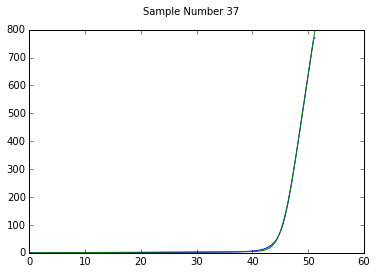

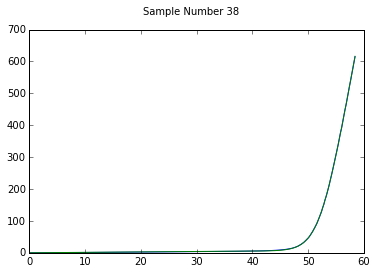

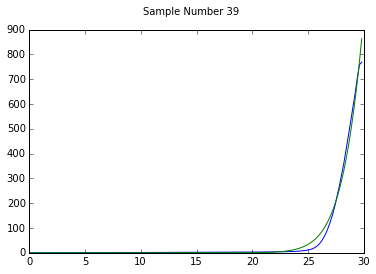

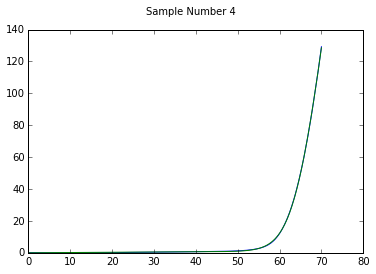

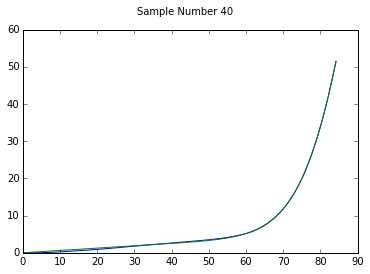

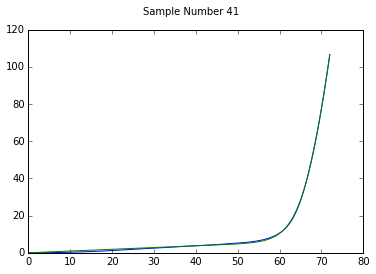

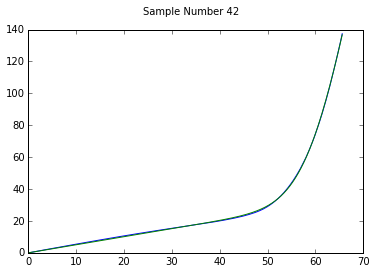

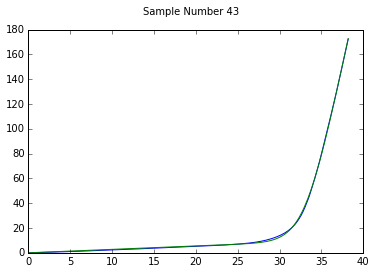

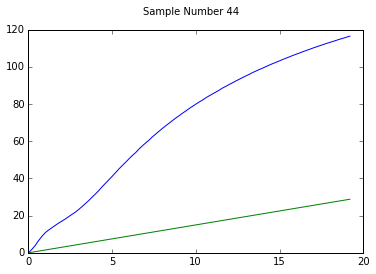

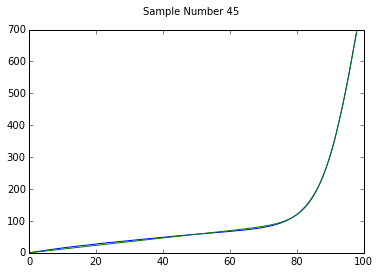

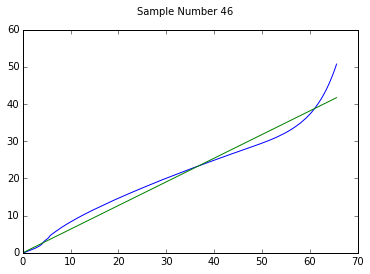

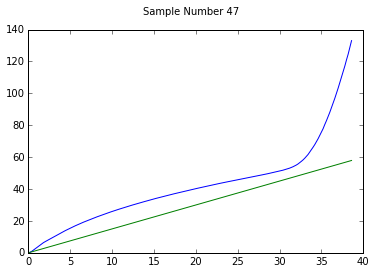

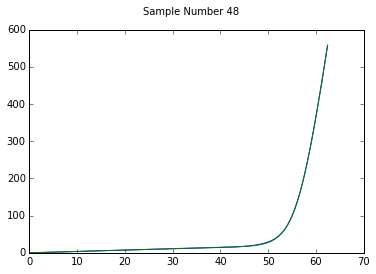

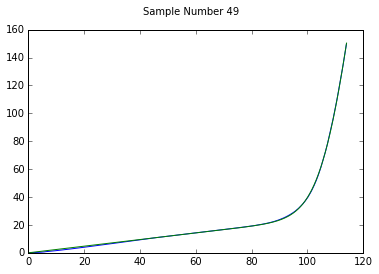

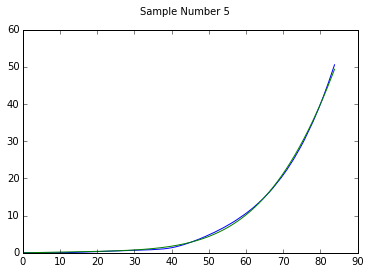

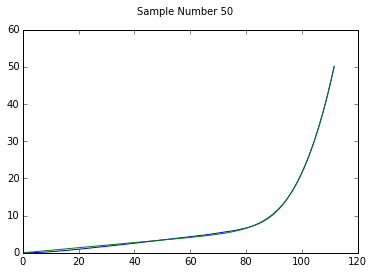

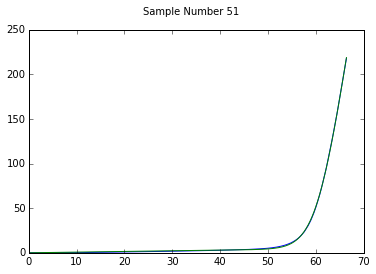

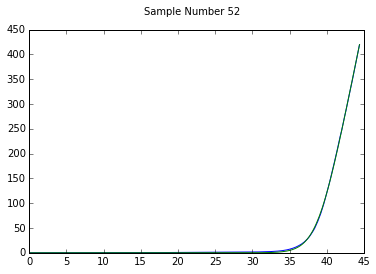

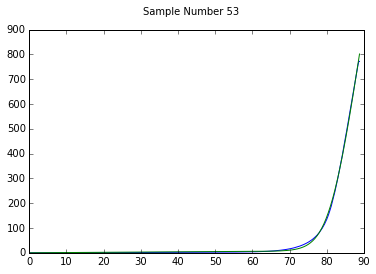

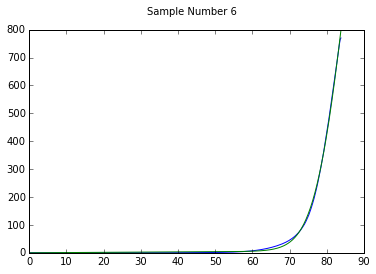

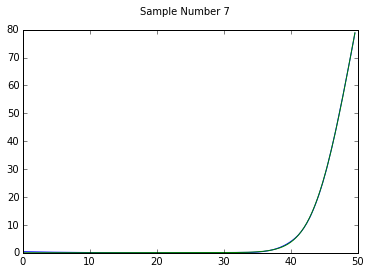

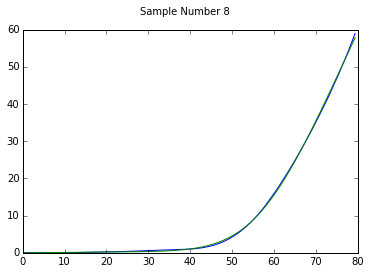

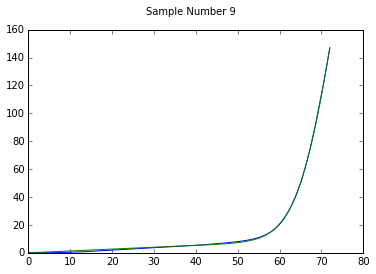

In [16]:
t = tm()


sample_number_all = []
stability_time_all = []

int_abs_err_all = []
ps_all = []

# cnt_all = []

with PdfPages('Thermomat Fitting Graph New Model 1.pdf') as pdf:
    for j, f in enumerate(Files):
        split_tm = tm ()
        time_data, conduct_data = DataFile(f).simple_data()
    
        # Parsing filename
        sample_number = file_parse(f)
        sample_number_all.append(sample_number)
        
        # Trim Data
        cut_point = find_cut_point(conduct_data)
        
        if cut_point != None:
            time_data = time_data[:cut_point]
            conduct_data = conduct_data[:cut_point]
            
        # Remove offset
        min_cond = min(conduct_data)
        conduct_data[:] = [cond - min_cond for cond in conduct_data]        
                    
        # Find max conductivity to set upper limit of initial beta value
        max_cond = max(conduct_data)
        ini_val_up_lim = [50.0, 500.0, 3.0*max_cond, 1.5]
        
        # Fit Data with multiple starts 
        starts = 10
        smallest_err = 10000000.0
        
        for i in range(starts):
#         cnt = 0
#         cnt_2 = 0

#         while cnt_2 < 40 and cnt < 40:
            ini_val = rand_ini_val(ini_val_up_lim)
            p = parameters(ini_val, ini_val_up_lim)
            result = minimize(f2min, p, args=(time_data, conduct_data))

            err_list = f2min(p, time_data, conduct_data)
            abs_err_list = map(abs, err_list)
            int_abs_err = trapz(abs_err_list, x=time_data)
#             print 'Error = ', int_abs_err
            
#             if int_abs_err < 450:
#                 cnt_2 += 1
    
#             cnt += 1
#             print 'Count ', cnt
#             print 'Count2 ', cnt_2
#             print 'Start ', i + 1
            
            smallest_err = min([smallest_err, int_abs_err])
            if smallest_err == int_abs_err:
                best_p = p
                
        int_abs_err_all.append(smallest_err)#smallest_err)
        ps_all.append(best_p)
#         cnt_all.append(cnt)
                
        # Plot fitted model and raw data
        fig = figure()
        fig.suptitle('Sample Number ' + sample_number)
        plot(time_data, conduct_data)
        plot(time_data, cond_model(best_p, time_data))
        
        pdf.savefig(fig)
        
        split_tm = tm() - split_tm
        print 'Completed Fit', (j + 1), 'in', round(split_tm, 2), '(s)'
#         print 'Sample Number ', sample_number
#         print '________________________'
        
req_time = tm() - t
print '******************'
print 'Time required (min) =', round(req_time/60.0, 2)

(array([ 36.,   6.,   1.,   2.,   3.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([    4.54957676,    57.45728537,   110.36499397,   163.27270257,
          216.18041118,   269.08811978,   321.99582839,   374.90353699,
          427.81124559,   480.7189542 ,   533.6266628 ,   586.53437141,
          639.44208001,   692.34978861,   745.25749722,   798.16520582,
          851.07291443,   903.98062303,   956.88833163,  1009.79604024,
         1062.70374884]),
 <a list of 20 Patch objects>)

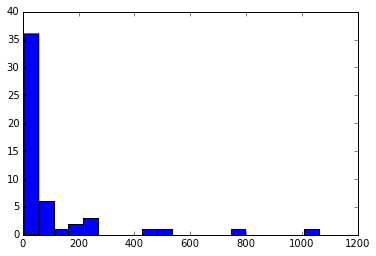

In [17]:
hist(int_abs_err_all, bins=20)

In [18]:
theta_all = []
tau_all =[]
beta_all = []
m_all = []

for p in ps_all:
    theta_all.append(p['theta'].value)
    tau_all.append(p['tau'].value)
    beta_all.append(p['beta'].value)
    m_all.append(p['m'].value)

In [19]:
# fitting_data = {'Sample Number': sample_number_all,
#                 'theta': theta_all,
#                 'tau': tau_all,
#                 'K': K_all,
#                 'Integral of the Absolute Error': int_abs_err_all
#                 }
fitting_data = [sample_number_all, theta_all, tau_all, beta_all, m_all, int_abs_err_all]
indeces = ['Sample Number', 'theta', 'tau', 'beta', 'm', 'Integral of the Absolute Error']

In [20]:
fitting_data_df = pd.DataFrame(data=fitting_data, index=indeces).transpose()
# fitting_data_df = fitting_data_df.sort('Sample Number')

fitting_data_df.to_csv('Thermomat_Fitted_Parameters_new_model_1.csv')

In [21]:
fitting_data_df

,Sample Number,theta,tau,beta,m,Integral of the Absolute Error
0,1,11.03598,72.39805,952.9467,0.02547605,62.63906
1,10,3.71179,48.71337,437.9283,0.005951426,35.23658
2,11,22.71666,35.1547,151.3154,0.1166652,38.41028
3,12,21.55855,40.25574,133.2487,0.3875212,43.90258
4,13,16.7546,89.48137,401.3595,0.0161002,23.13671
5,14,16.01174,47.69862,36.3887,0.1572703,19.15143
6,15,26.29016,70.19575,606.4072,0.1230292,152.8735
7,16,3.684347,297.6508,294.3463,0.04699005,23.79294
8,17,12.73877,46.63753,50.19723,0.06400245,5.762859
9,18,13.01136,171.9543,2314.789,0.2364353,438.0394
